# 优化算法

到目前为止，你一直使用梯度下降来更新参数并使损失降至最低。 在本笔记本中，你将学习更多高级的优化方法，以加快学习速度，甚至可以使你的损失函数的获得更低的最终值。 一个好的优化算法可以使需要训练几天的网络，训练仅仅几个小时就能获得良好的结果。
梯度下降好比在损失函数$J$上“下坡”。就像下图：

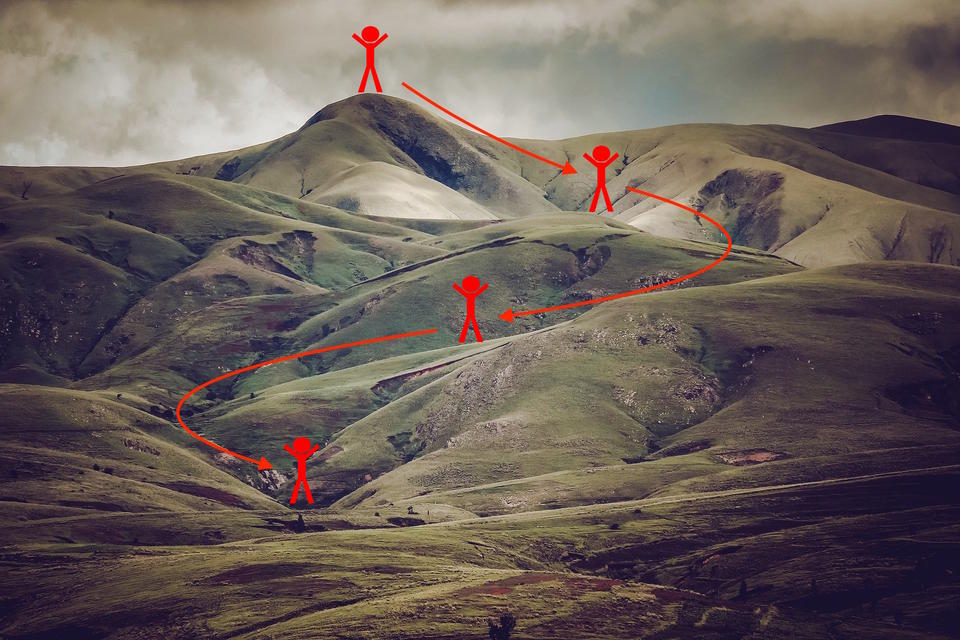

在训练的每个步骤中，你都按照一定的方向更新参数，以尝试到达最低点。

首先，请运行以下代码以导入所需的库。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCase import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 梯度下降

  在机器学习中，最简单就是没有任何优化的梯度下降(GD,Gradient Descent)，我们每一次循环都是对整个训练集进行学习，这叫做批量梯度下降(Batch Gradient Descent)，我们之前说过了最核心的参数更新的公式，这里我们再来看一下：

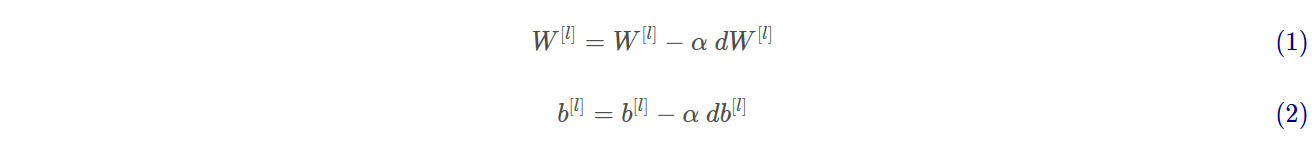

   $l$是指当前的层数
   
   $\alpha$是学习率

所有的参数都在一个叫做parameters的字典类型的变量里面，我们来看看它怎样实现的吧，虽然我们已经实现过它很多次了。

In [3]:
# GRADED FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] -learning_rate*grads["db" + str(l+1)]
        ### END CODE HERE ###
        
    return parameters

In [4]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


它的一种变体是随机梯度下降（SGD），它相当于mini版的批次梯度下降，其中每个mini-batch只有一个数据示例。刚刚实现的更新规则不会更改。不同的是，SGD一次仅在一个训练数据上计算梯度，而不是在整个训练集合上计算梯度。

对于随机梯度下降，在更新梯度之前，只使用1个训练样例。当训练集大时，SGD可以更新的更快。但是这些参数会向最小值“摆动”而不是平稳地收敛。下图是一个演示例子：

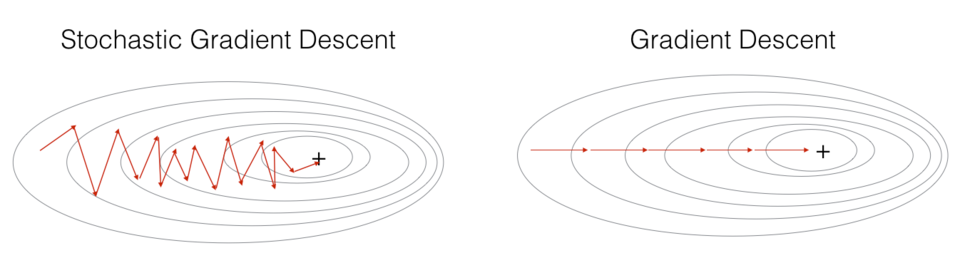

“+”表示损失的最小值。 SGD造成许多振荡以达到收敛。但是每个step中，计算SGD比使用GD更快，因为它仅使用一个训练示例（相对于GD的整个批次）。

实际上，如果你既不使用整个训练集也不使用一个训练示例来执行每次更新，则通常会得到更快的结果。小批量梯度下降法在每个步骤中使用中间数量的示例。通过小批量梯度下降，你可以遍历小批量，而不是遍历各个训练示例。

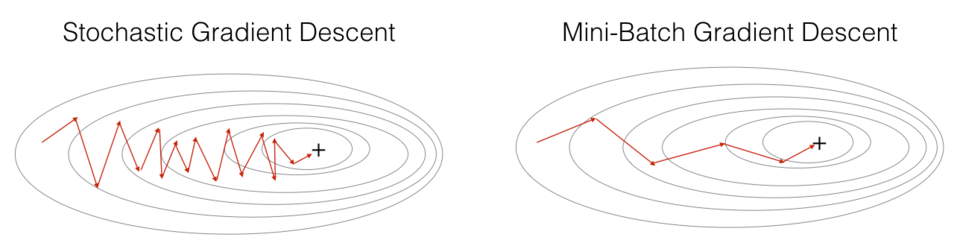

“+”表示损失的最小值。在优化算法中使用mini-batch批处理通常可以加快优化速度。

**你应该记住**：

    梯度下降，小批量梯度下降和随机梯度下降之间的差异是用于执行一个更新步骤的数据数量。
    必须调整超参数学习率α。
    在小批量的情况下，通常它会胜过梯度下降或随机梯度下降（尤其是训练集较大时）。 

## 2 Mini-Batch 梯度下降

让我们学习如何从训练集（X，Y）中构建小批次数据。

分两个步骤：

  **Shuffle**：如下所示，创建训练集（X，Y）的随机打乱版本。X和Y中的每一列代表一个训练示例。注意，随机打乱是在X和Y之间同步完成的。这样，在随机打乱之后，X的$i^{th}$列就是对应于Y中$i^{th}$标签的示例。打乱步骤可确保该示例将随机分为不同小批。 
  
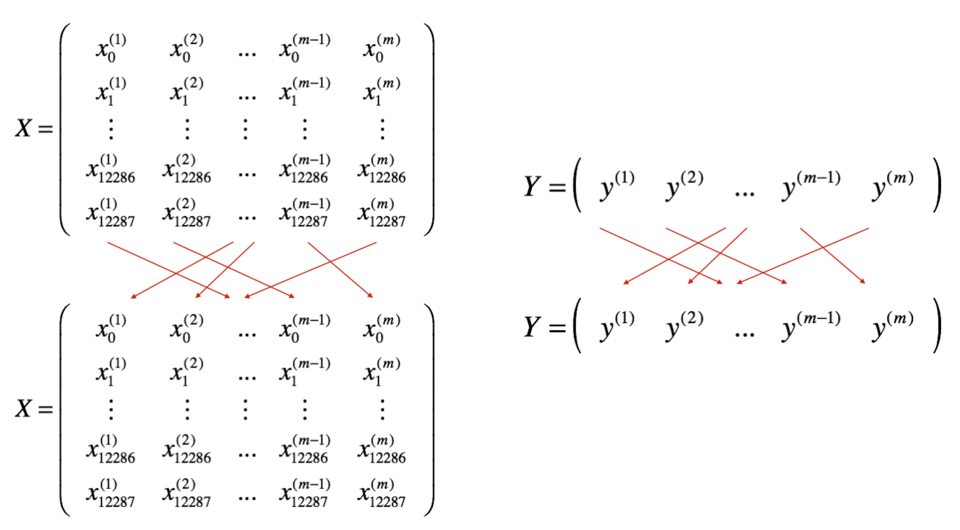
  
  **Partition**：将打乱后的（X，Y）划分为大小为mini_batch_size（此处为64）的小批处理。请注意，训练示例的数量并不总是可以被mini_batch_size整除。最后的小批量可能较小，但是你不必担心，当最终的迷你批处理小于完整的mini_batch_size时，它将如下图所示： 
  
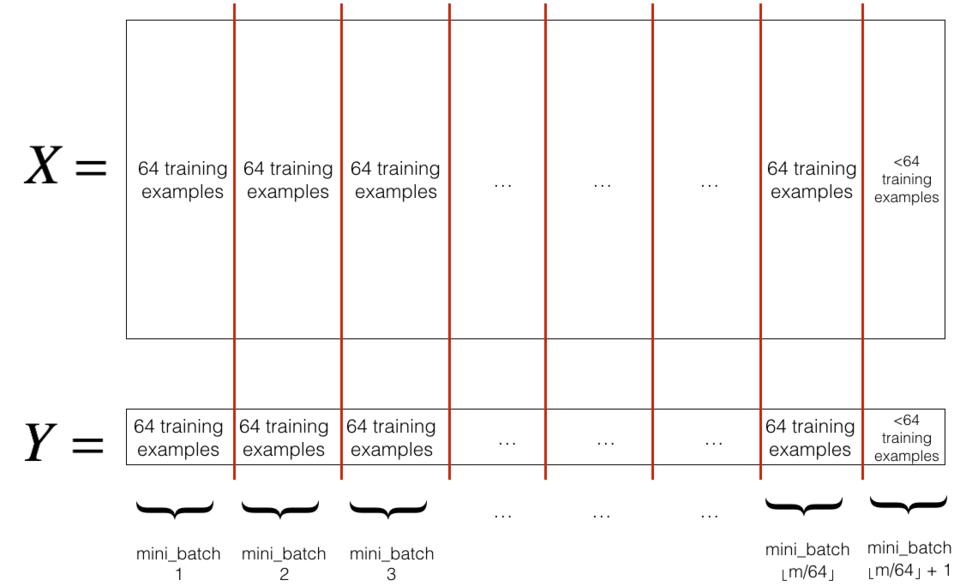

**练习**：实现random_mini_batches。我们为你编码好了shuffling部分。为了帮助你实现partitioning部分，我们为你提供了以下代码，用于选择$1^{st}$和$2^{nd}$小批次的索引：

In [5]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [6]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]



**你应该记住**：

    Shuffling和Partitioning是构建小批次数据所需的两个步骤
    通常选择2的幂作为最小批量大小，例如64、128、256、512。


## 3 Momentum

因为小批量梯度下降仅在看到示例的子集后才进行参数更新，所以更新的方向具有一定的差异，因此小批量梯度下降所采取的路径将“朝着收敛”振荡。利用冲量则可以减少这些振荡。

冲量考虑了过去的梯度以平滑更新。我们将先前梯度的“方向”存储在变量$v$中。这将是先前步骤中梯度的指数加权平均值，你也可以将$v$看作是下坡滚动的球的“速度”，根据山坡的坡度/坡度的方向来提高速度（和冲量）。

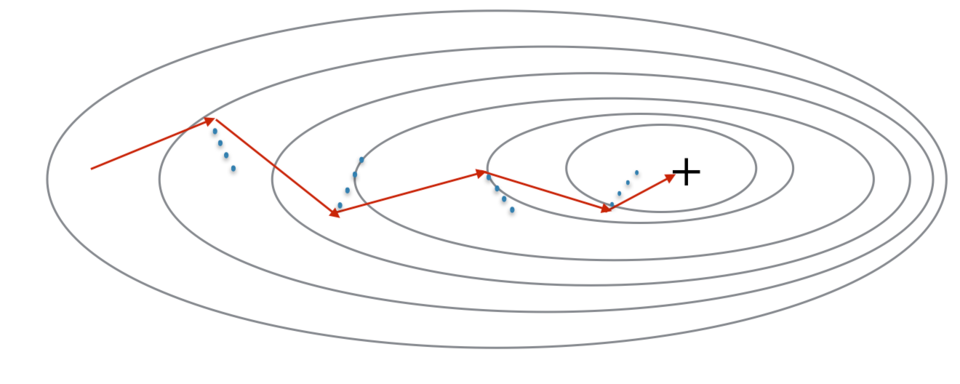

红色箭头显示了带冲量的小批次梯度下降步骤所采取的方向。蓝点表示每一步的梯度方向（相对于当前的小批量）。让梯度影响$v$而不是仅遵循梯度，然后朝$v$的方向迈出一步。

**练习**：初始化速度。速度$v$是一个Python字典，需要使用零数组进行初始化。它的键与grads词典中的键相同，即$l=1,2,...,L$：



**注意**：迭代器l在for循环中从0开始，而第一个参数是v["dW1"]和v["db1"]（在上标中为“1”）。这就是为什么我们在“for”循环中将l转换为l+1的原因。

In [7]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        ### END CODE HERE ###
        
    return v

In [8]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


**练习**：实现带冲量的参数更新。冲量更新规则是，对于$l=1,2,...,L$:

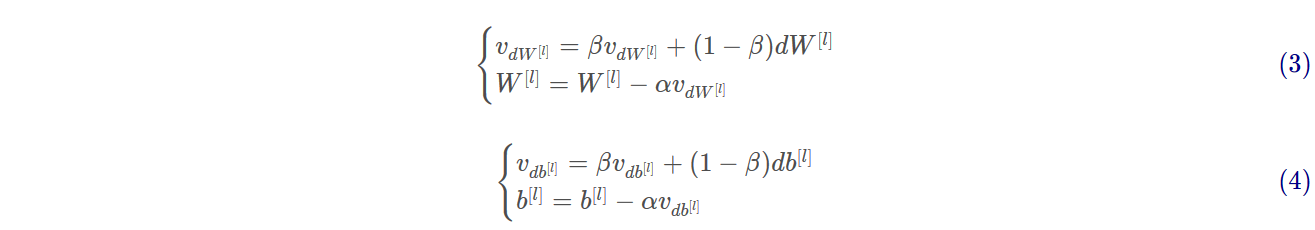

其中L是层数，$\beta$是动量，$\alpha$是学习率。

In [9]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l + 1)] = beta*v["dW" + str(l + 1)]+(1-beta)*grads['dW' + str(l+1)]
        v["db" + str(l + 1)] = beta*v["db" + str(l + 1)]+(1-beta)*grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l + 1)] = parameters['W' + str(l+1)] - learning_rate*v["dW" + str(l + 1)] 
        parameters["b" + str(l + 1)] = parameters['b' + str(l+1)] - learning_rate*v["db" + str(l + 1)] 
        ### END CODE HERE ###
        
    return parameters, v

In [10]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


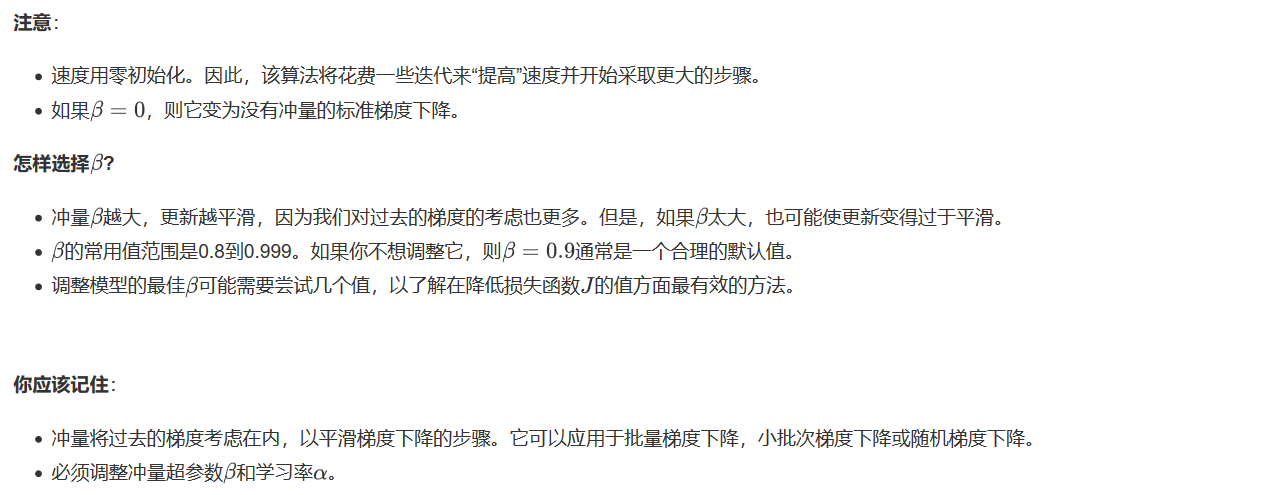

## 4 Adam

Adam是训练神经网络最有效的优化算法之一。它结合了RMSProp和Momentum的优点。

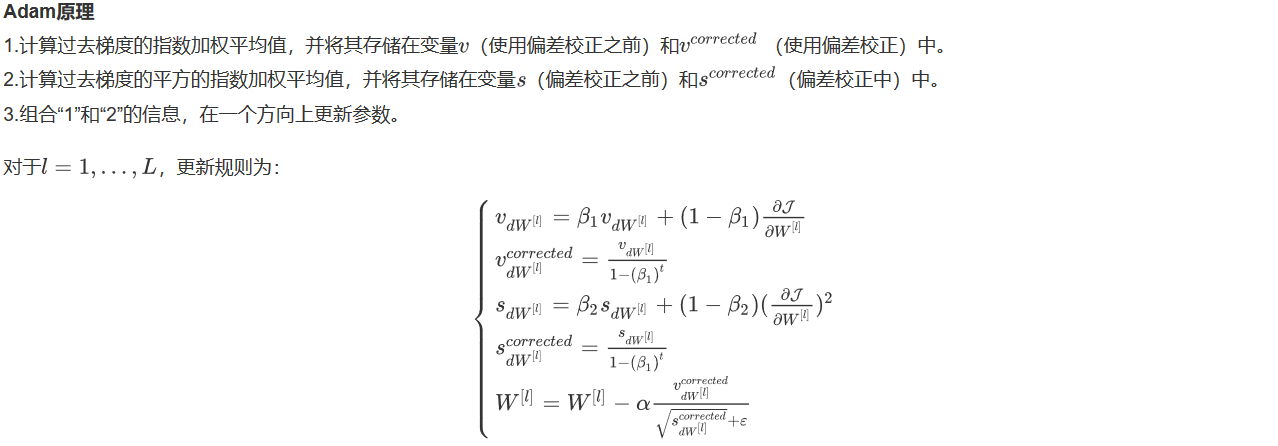

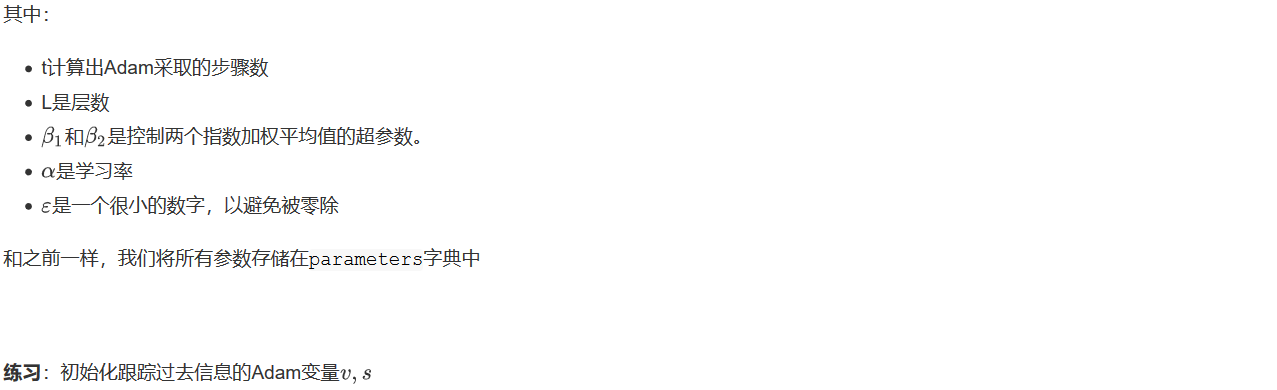

In [11]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l + 1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l + 1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l + 1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l + 1)] = np.zeros(parameters["b" + str(l+1)].shape)
        ### END CODE HERE ###
    
    return v, s

In [12]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


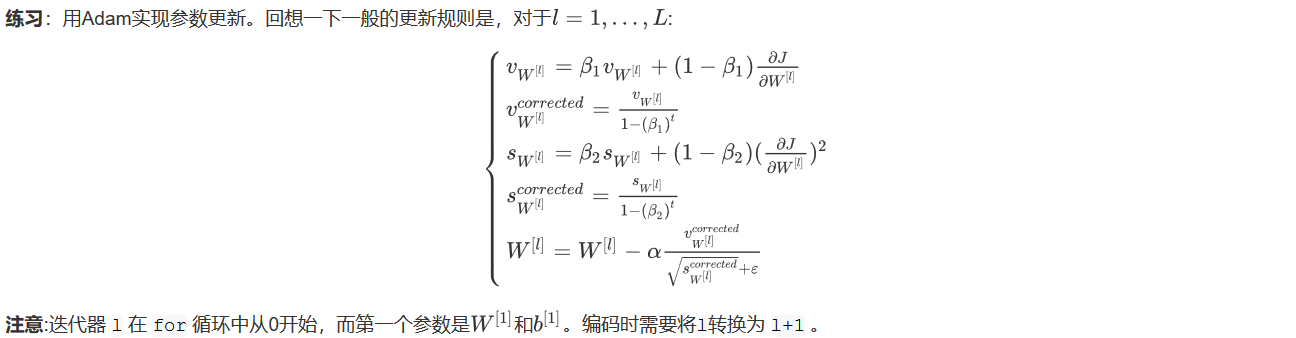

In [13]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l + 1)] = beta1*v["dW" + str(l + 1)] +(1-beta1)*grads['dW' + str(l+1)]
        v["db" + str(l + 1)] = beta1*v["db" + str(l + 1)] +(1-beta1)*grads['db' + str(l+1)]
        ### END CODE HERE ###

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)]/(1-(beta1)**t)
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)]/(1-(beta1)**t)
        ### END CODE HERE ###

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l + 1)] =beta2*s["dW" + str(l + 1)] + (1-beta2)*(grads['dW' + str(l+1)]**2)
        s["db" + str(l + 1)] = beta2*s["db" + str(l + 1)] + (1-beta2)*(grads['db' + str(l+1)]**2)
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l + 1)] =s["dW" + str(l + 1)]/(1-(beta2)**t)
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)]/(1-(beta2)**t)
        ### END CODE HERE ###

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)]-learning_rate*(v_corrected["dW" + str(l + 1)]/np.sqrt( s_corrected["dW" + str(l + 1)]+epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)]-learning_rate*(v_corrected["db" + str(l + 1)]/np.sqrt( s_corrected["db" + str(l + 1)]+epsilon))
        ### END CODE HERE ###
        
    return parameters, v, s

In [14]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = [[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]




现在，你学习了三种有效的优化算法（小批次梯度下降，冲量，Adam）。让我们使用每个优化器来实现一个模型，并观察其中的差异。
## 5 不同优化算法的模型

我们使用“moons”数据集来测试不同的优化方法。（该数据集被命名为“月亮”，因为两个类别的数据看起来有点像月牙。）


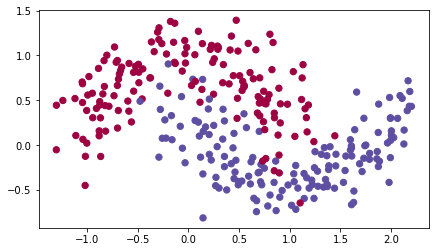

In [15]:
train_X, train_Y = load_dataset()



我们已经实现了一个三层的神经网络。你将使用以下方法进行训练：

    小批次 Gradient Descent:它将调用你的函数：
         - update_parameters_with_gd（）
    小批次 冲量：它将调用你的函数：
         - initialize_velocity（）和update_parameters_with_momentum（）
    小批次 Adam：它将调用你的函数：
         - initialize_adam（）和update_parameters_with_adam（）



In [17]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters



现在，你将依次使用3种优化方法来运行此神经网络。
### 5.1 小批量梯度下降

运行以下代码以查看模型如何进行小批量梯度下降。


Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


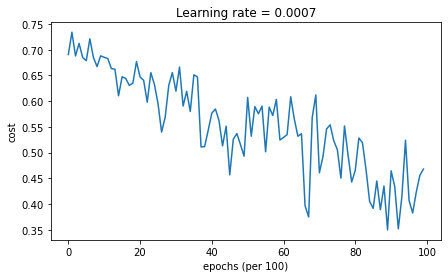

Accuracy: 0.7966666666666666


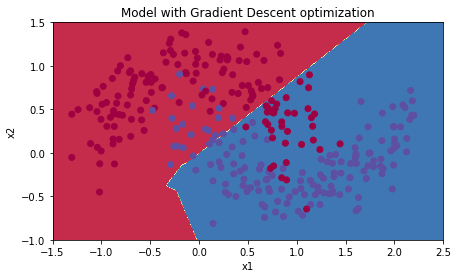

In [19]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


### 5.2 带冲量的小批量梯度下降

运行以下代码，以查看模型如何使用冲量。因为此示例相对简单，所以使用冲量的收益很小。但是对于更复杂的问题，你可能会看到更大的收获。


Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


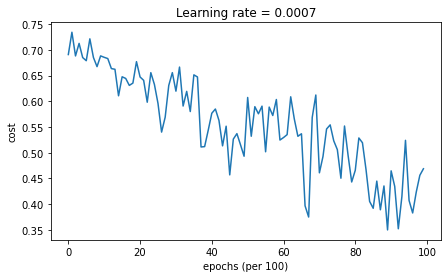

Accuracy: 0.7966666666666666


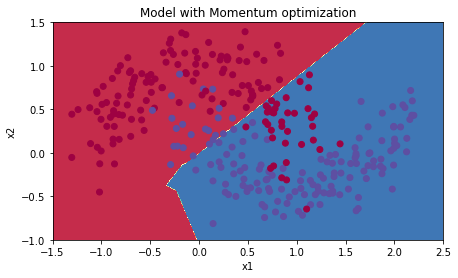

In [20]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


### 5.3 Adam模式的小批量梯度下降

运行以下代码以查看使用Adam的模型表现


Cost after epoch 0: 0.690552
Cost after epoch 1000: 0.185501
Cost after epoch 2000: 0.150830
Cost after epoch 3000: 0.074454
Cost after epoch 4000: 0.125959
Cost after epoch 5000: 0.104344
Cost after epoch 6000: 0.100676
Cost after epoch 7000: 0.031652
Cost after epoch 8000: 0.111973
Cost after epoch 9000: 0.197940


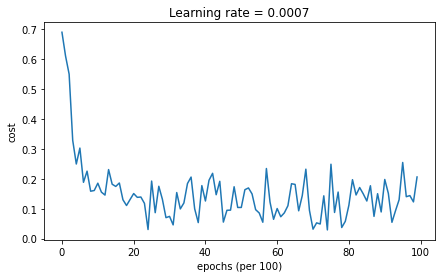

Accuracy: 0.94


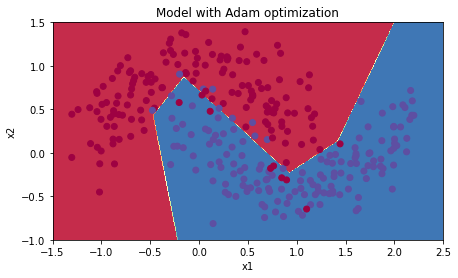

In [21]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.4 总结
|优化方法|准确度|模型损失|
|:----:|:----:|:----:|
|Gradient descent|79.70％|振荡|
|Momentum|79.70％|振荡|
|Adam|94％|更光滑|

冲量通常会有所帮助，但是鉴于学习率低和数据集过于简单，其影响几乎可以忽略不计。同样，你看到损失的巨大波动是因为对于优化算法，某些小批处理比其他小批处理更为困难。

另一方面，Adam明显胜过小批次梯度下降和冲量。如果你在此简单数据集上运行更多epoch，则这三种方法都将产生非常好的结果。但是，Adam收敛得更快。

Adam的优势包括：

    相对较低的内存要求（尽管高于梯度下降和带冲量的梯度下降）
    即使很少调整超参数，通常也能很好地工作（α除外） 